In [100]:
import astropy.table as table
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import click

from astropy.cosmology import Planck15 as cosmo
import astropy.constants as const

redshift = 0.1136
dist = cosmo.luminosity_distance(redshift).to(u.cm)
dist_cm = dist.value
dist_pc = dist.to(u.pc).value
dist_mod = 5*np.log10(dist_pc) - 5

EXTINCTION_COEFF = {
    'g': 3.303,
    'r': 2.285,
    'i': 1.698,
    'z': 1.263,
    # from https://irsa.ipac.caltech.edu/workspace/TMP_3mtiHn_9142/DUST/SN2004aw.v0001/extinction.html
    'U': 4.107,
    'B': 3.641,
    'V': 2.682,
    'R': 2.119,
    'I': 1.516,
    'J': 0.723,
    'H': 0.460,
    'K': 0.310,
    'time': 0
}

BANDS = ["g'", "r'", 'U', 'B', 'V', 'R', 'I', 'J', 'H', 'K', 'UVW1', 'UVM2', 'UVW2']

In [51]:
# load data
raw = table.Table.read('../data/comparison/SN2015bn.csv')
actual_obs = raw['upperlimit'] == 'F'
#raw[actual_obs]
mjd_min = 0
mjd_max = raw['time'].max()
mjd_peak = 0
for band in BANDS:
    print(band)
    idx = np.logical_and(actual_obs, raw['band'] == band)
    print('\tFound: %d' % np.count_nonzero(idx))
    print('\tMin=%.1f Max=%.1f' % (raw['time'][idx].min(), raw['time'][idx].max()))
    if mjd_min < raw['time'][idx].min():
        mjd_min = raw['time'][idx].min()
    if mjd_max > raw['time'][idx].max():
        mjd_max = raw['time'][idx].max()
    if band == "g'":
        ct = np.argmin(raw['magnitude'][idx])
        mjd_peak = raw['time'][idx][ct]
raw['Phase'] = raw['time']-mjd_peak
idx = np.logical_and(actual_obs, np.logical_and(raw['time'] > mjd_min, raw['time'] < mjd_max))
raw[idx]

g'
	Found: 62
	Min=57071.6 Max=57488.2
r'
	Found: 72
	Min=57068.5 Max=57488.2
U
	Found: 68
	Min=57072.4 Max=57390.3
B
	Found: 97
	Min=57072.4 Max=57390.3
V
	Found: 125
	Min=57042.0 Max=57390.3
R
	Found: 89
	Min=57074.2 Max=57221.0
I
	Found: 85
	Min=57074.2 Max=57210.0
J
	Found: 11
	Min=57092.2 Max=57492.1
H
	Found: 10
	Min=57092.2 Max=57492.1
K
	Found: 10
	Min=57092.2 Max=57492.1
UVW1
	Found: 43
	Min=57072.4 Max=57390.3
UVM2
	Found: 48
	Min=57072.4 Max=57390.3
UVW2
	Found: 46
	Min=57072.4 Max=57232.4


<Table length=604>
 event      time    ...        Phase       
  str8    float64   ...       float64      
-------- ---------- ... -------------------
SN2015bn   57093.02 ... -2.9100000000034925
SN2015bn   57093.02 ... -2.9100000000034925
SN2015bn   57093.02 ... -2.9100000000034925
SN2015bn   57093.02 ... -2.9100000000034925
SN2015bn   57093.02 ... -2.9100000000034925
SN2015bn 57093.7628 ...  -2.167200000003504
SN2015bn  57093.764 ...  -2.165999999997439
SN2015bn  57093.764 ...  -2.165999999997439
SN2015bn  57093.764 ...  -2.165999999997439
SN2015bn  57093.764 ...  -2.165999999997439
     ...        ... ...                 ...
SN2015bn 57200.9018 ...  104.97179999999935
SN2015bn 57201.8965 ...  105.96650000000227
SN2015bn    57205.7 ...   109.7699999999968
SN2015bn    57205.7 ...   109.7699999999968
SN2015bn    57205.7 ...   109.7699999999968
SN2015bn   57206.34 ...  110.40999999999622
SN2015bn   57206.34 ...  110.40999999999622
SN2015bn   57206.34 ...  110.40999999999622
SN2015bn 57206.8328 ...   110.9027999999962
SN2015bn  57206.833 ...  110.90299999999843

In [63]:
for band in BANDS:
    print(band)
    i = np.logical_and(actual_obs, raw['band'] == band)
    print(np.unique(raw[i]['telescope']))

g'
telescope
---------
    LCOGT
       LT
      NTT
r'
telescope
---------
    LCOGT
       LT
      NTT
      PS1
U
telescope
---------
    Swift
B
telescope
---------
       --
    Swift
    lulin
V
telescope
---------
   ASASSN
       --
    Swift
    lulin
R
telescope
---------
       --
    lulin
I
telescope
---------
       --
    lulin
J
telescope
---------
      NOT
     SOFI
H
telescope
---------
      NOT
     SOFI
K
telescope
---------
      NOT
     SOFI
UVW1
telescope
---------
    Swift
UVM2
telescope
---------
    Swift
UVW2
telescope
---------
    Swift


In [89]:
# interpolate that stuff..
mjd_grid = np.linspace(mjd_min, mjd_max-40)
interp = {}
for band in BANDS:
    band_idx = np.logical_and(idx, raw['band'] == band)
    mag = raw['magnitude'][band_idx]
    time = raw['time'][band_idx]
    interp[band] = np.interp(mjd_grid, time, mag)
t = table.Table(interp)
t['time'] = mjd_grid
t

<Table length=50>
        g'                 r'         ...        UVW2               time       
     float64            float64       ...      float64            float64      
------------------ ------------------ ... ------------------ ------------------
             16.63              16.78 ...             17.181           57092.17
 16.63399558742414 16.768013237727587 ...             17.181 57093.759183673465
16.626461301501795  16.71013605442194 ...  17.16787944067234  57095.34836734694
16.613759518732852 16.781278556198554 ... 17.195884286374824 57096.937551020404
16.619689308559245 16.799067925677733 ...  17.22388913207744  57098.52673469388
16.616148546375076 16.769188371000606 ... 17.131692624202998 57100.115918367344
16.612084138003016 16.736673104024135 ...  17.13125846846224  57101.70510204082
16.621851311953364 16.676006493506623 ... 17.168937912920924 57103.294285714284
16.646175551853325  16.75481673266293 ...  17.26268950851722  57104.88346938775
16.670702216370366 16.840087777046296 ... 17.356441104113948 57106.472653061224
               ...                ... ...                ...                ...
17.599575255101993 17.439764030612217 ... 19.198673664871567 57155.737346938775
17.615823541537857 17.498019652305473 ...  19.21079763966284  57157.32653061225
17.631875901875915  17.55687830687835 ...  19.22292161445406 57158.915714285715
 17.64792826221397 17.615736961451223 ... 19.235045589245278  57160.50489795918
 17.72886863483296              17.66 ...  19.28901436026652 57162.094081632655
17.795587369276024 17.583381053914035 ... 19.414138430465652  57163.68326530612
 17.82721291501682 17.630819372525224 ...  19.53926250066536 57165.272448979595
17.858838460757465   17.6782576911362 ... 19.664386570864494  57166.86163265306
17.908839603638253 17.696587793012004 ...   19.7895106410642 57168.450816326535
17.959541375872476 17.713808049535636 ... 19.914634711263332           57170.04

In [90]:
# lyman params
lyman_bc_params_gr = np.array([
    0.054, -0.195, -0.719, # c0 c1 c2
    0.076 # rms
])

lyman_bc_params_bv = np.array([
    -0.083, -0.139, -0.691, # c0 c1 c2
    0.109 #rms
])

lyman_cool_params_gr = np.array([
    -0.146, 0.479, -2.257,
    0.078
])
lyman_cool_params_bv = np.array([
    -0.393, 0.786, -2.124,
    0.089
])

COLOR_RANGES = {
    'pbc_gr': (-0.3, 1.0),
    'bc_gr': (-0.3, 1.0),
    'pbc_gi': (-0.8, 1.1),
    'bc_gi': (-0.8, 1.1),
    'bc_bv': (0, 1.3),
    'cool_gr': (-0.3, 0.3),
    'cool_bv': (-0.2, 0.5)
}

VARIANTS = {
    'pbc_gr': ("g'", "r'"),
    'bc_gr': ("g'", "r'"),
    'pbc_gi': ("g'", "i'"),
    'bc_gi': ("g'", "i'"),
    'bc_bv': ('B', 'V'),
    'cool_gr': ("g'", "r'"),
    'cool_bv': ('B', 'V')
}

def compute_bol_mag(mag_g, mag_r, method):
    if method == 'bc_gr':
        c0, c1, c2, rms = lyman_bc_params_gr
    elif method == 'bc_bv':
        c0, c1, c2, rms = lyman_bc_params_bv
    elif method == 'cool_gr':
        c0, c1, c2, rms = lyman_cool_params_gr
    elif method == 'cool_bv':
        c0, c1, c2, rms = lyman_cool_params_bv
    else:
        raise ValueError('Unknown method: %s' % method)

    dmag = mag_g - mag_r

    # validate color range
    color_min = dmag.min()
    color_max = dmag.max()
    
    if color_min < COLOR_RANGES[method][0]:
        print('* WARN: color in lc exceeds lyman (min lc = %f < %f)' % (color_min, COLOR_RANGES[method][0]))
    if color_max > COLOR_RANGES[method][1]:
        print('* WARN: color in lc exceeds lyman (max lc = %f > %f)' % (color_max, COLOR_RANGES[method][1]))
    invalid = np.logical_or(dmag < COLOR_RANGES[method][0], dmag > COLOR_RANGES[method][1])
    
    bol_correction = c0 + c1*dmag + c2*dmag ** 2
    
    return mag_g + bol_correction, rms, invalid

def convert_luminosity(abs_mag):
    luminosity = (const.L_sun.cgs.value)*10 ** ((4.74 - abs_mag)/2.5)
    return luminosity

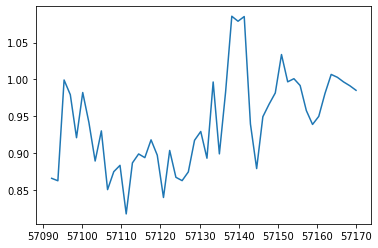

In [96]:
bol_gr, rms, invalid = compute_bol_mag(interp["g'"], interp["r'"], 'bc_gr')
bol_bv, rms, invalid = compute_bol_mag(interp['B'], interp['V'], 'bc_bv')
lum_gr = convert_luminosity(bol_gr-dist_mod)
lum_bv = convert_luminosity(bol_bv-dist_mod)
plt.plot(t['time'], lum_gr/lum_bv)

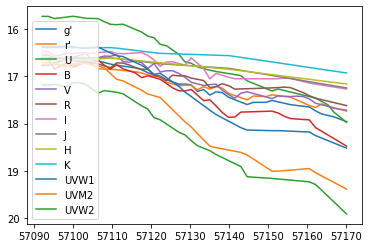

In [92]:
for band in BANDS:
    plt.plot(t['time'], t[band], label=band)
plt.legend()
plt.gca().invert_yaxis()

Text(0, 0.5, 'Ratio UBVRIJHK Integration/Lyman')

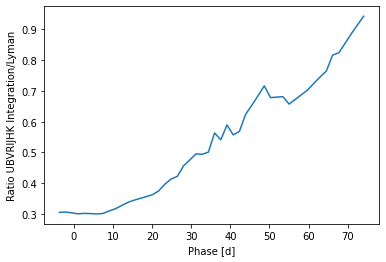

In [103]:
# ok.. now do the direct integration..
# (band, central wavelength, fwhm, zero_flux)
INS_OLD = [
    ('U', 3617.41, 595.75, 3.97645e-9, 20.91, 0.06),
    ('B', 4346.66, 1013.59, 6.30566e-9, 19.96, 0.06),
    ('V', 5417.18, 891.04, 3.78699e-9, 18.35, 0.03),
    ('R', 6464.12, 1230.80, 2.26888e-9, 17.61, 0.03),
    ('I', 8682.26, 2955.82, 9.66006e-10, 17.00, 0.03),
    # JHK from TNG+NICS
    ('J', 12789.08, 2965.63, 2.87698e-10, 16.25, 0.09),
    ('H', 16288.24, 2963.05, 1.20622e-10, 15.99, 0.14),
    ('K', 22038.01, 3378.31, 4.0487e-11, 15.95, 0.13)
]
# (band, central wavelength, fwhm, zero_flux)
# Swift UBV, LaCumbres RI, LS/SOFI JHK all Vega
INS_VEGA = [
    ('U', 3492.67, 778.49, 3.58033e-9),
    ('B', 4377.97, 978.33, 6.44317e-9),
    ('V', 5439.64, 744.99, 3.72255e-9),
    ('R', 6457.54, 1298.29, 2.28509e-9),
    ('I', 8895.81, 3155.25, 9.19679e-10),
    ('J', 12536.58, 2886.97, 3.0717e-10),
    ('H', 16519.80, 2959.98, 1.14771e-10),
    ('K', 21638.30, 2745.48, 4.30954e-11)
]
INS=INS_VEGA
int_bands = [x[0] for x in INS]
cent_wave = [x[1] for x in INS]
fwhm = [x[2] for x in INS]
zero_flux = [x[3] for x in INS]

lum_int = np.empty(len(lum_gr))
for i,row in enumerate(t):
    mags = list(map(lambda band: row[band], int_bands))
    fluxes = np.array(zero_flux)*10**(-0.4*np.array(mags))
    f_qbol = np.trapz(fluxes, cent_wave)
    lums_qbol = 4*np.pi*dist_cm**2*f_qbol
    lum_int[i] = lums_qbol
plt.plot(t['time']-mjd_peak, lums_qbol/lum_gr)
plt.xlabel('Phase [d]')
plt.ylabel('Ratio UBVRIJHK Integration/Lyman')

[15.87, 15.947, 15.51, 15.333, 15.214, 14.8, 14.725, 14.527]
[15.699, 15.57, 15.111, 14.92, 14.737, 14.42, 14.393, 14.29]
[16.046, 15.698, 15.061, 14.838, 14.56, 14.285, 14.151, 13.956]
[17.6, 17.043, 15.874, 15.322, 14.969, 14.52, 14.4, 14.3]
[18.05, 17.437, 16.286, 15.78, 15.33, 14.81, 14.79, 14.7]
[18.141, 17.702, 16.568, 16.0, 15.508, 15.069, 14.897, 14.924]


Text(0, 0.5, 'Ratio UBVRIJHK Integration/Lyman')

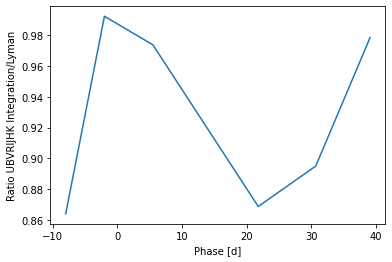

In [102]:
INS=INS_VEGA
int_bands = [x[0] for x in INS]
cent_wave = [x[1] for x in INS]
fwhm = [x[2] for x in INS]
zero_flux = [x[3] for x in INS]

ebv_sn2009jf = 0.117

redshift_sn2009jf = 0.0079
dist09jf = cosmo.luminosity_distance(redshift_sn2009jf).to(u.cm)
dist09jf_cm = dist09jf.value
dist09jf_pc = dist09jf.to(u.pc).value
dist09jf_mod = 5*np.log10(dist09jf_pc) - 5

# read SN2009jf
# UBVRI (NOT); JHK
# (phase UBVRIJHKgr)
sn2009jf_obs = [
    (-8, 15.87, 15.947, 15.510, 15.333, 15.214, 14.8, 14.725, 14.527, 15.569, 15.343),
    (-2, 15.699, 15.570, 15.111, 14.920, 14.737, 14.42, 14.393, 14.29, 15.327, 15.098),
    (5.5, 16.046, 15.698, 15.061, 14.838, 14.560, 14.285, 14.151, 13.956, 15.429, 14.944),
    (21.8, 17.6, 17.043, 15.874, 15.322, 14.969, 14.52, 14.40, 14.30, 16.408, 15.499),
    (30.7, 18.050, 17.437, 16.286, 15.780, 15.330, 14.81, 14.79, 14.70, 16.967, 15.969),
    (39.1, 18.141, 17.702, 16.568, 16.000, 15.508, 15.069, 14.897, 14.924, 17.167, 16.241),
   # (259.3, 21.00, 20.483, 20.164, 19.368, 19.273, 19.34, 18.57, 19.08)
]
sn2009jf_obs_dict = {}
for i,k in enumerate(['time']+int_bands+['g','r']):
    sn2009jf_obs_dict[k]=np.array([x[i] for x in sn2009jf_obs])# - EXTINCTION_COEFF[k]*ebv_sn2009jf
t09jf=table.Table(sn2009jf_obs_dict)

bol_bv, rms, invalid = compute_bol_mag(t09jf['g'], t09jf['r'], 'bc_gr')
lum_bv09jf = convert_luminosity(bol_bv-dist09jf_mod)

lum_int09jf = np.empty(len(sn2009jf_obs))
for i,row in enumerate(t09jf):
    mags = list(map(lambda band: row[band], int_bands))
    print(mags)
    fluxes = np.array(zero_flux)*10**(-0.4*np.array(mags))
    f_qbol = np.trapz(fluxes, cent_wave)
    lums_qbol = 4*np.pi*dist09jf_cm**2*f_qbol
    lum_int09jf[i] = lums_qbol
plt.plot(t09jf['time'], lum_int09jf/lum_bv09jf)
plt.xlabel('Phase [d]')
plt.ylabel('Ratio UBVRIJHK Integration/Lyman')